# **Projet 6 :** Classifiez automatiquement des biens de consommation

## Notebook de modilsation avec le word embedding

### Import

In [1]:
%pylab inline
import os
import json
import pandas as pd
import uuid
import multiprocessing
import seaborn as sns
from matplotlib.colors import ListedColormap

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import preprocessing, manifold, cluster, metrics

import gensim

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model

print(tf.__version__)
print(tf.keras.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.8.0
2.8.0
Num GPUs Available:  0
True


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Configuration

In [4]:
%load_ext autoreload
%autoreload 2

# configurations pandas
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

### Chargement des données

In [5]:
path = './data/Flipkart'
data = pd.read_csv(os.path.join(path,'flipkart_com-ecommerce_sample_1050.csv'))
print(data.shape)

data.drop([
    'crawl_timestamp', 'product_url', 'pid', 'retail_price', 'discounted_price', 'is_FK_Advantage_product', 'product_rating',
    'overall_rating','brand', 'product_category_1', 'product_category_2', 'product_category_3', 'product_category_4',
    'product_category_5', 'product_category_6'
], axis=1, inplace=True, errors='ignore')

def product_specification_decode(json_str):
    s = json_str.lower().replace("=>", ':').replace('{"product_specification":nil}', '{"product_specification":""}')
    return json.loads(s)

def product_category_tree_decode(json_str):
    cat_list = json.loads(json_str.lower())
    assert(isinstance(cat_list, list))
    assert(len(cat_list) == 1)
    return [s.strip() for s in cat_list[0].split('>>')]

data['uniq_id'] = data['uniq_id'].apply(lambda x: uuid.UUID(x))
data['product_category_tree'] = data['product_category_tree'].apply(product_category_tree_decode)
data[[f"product_category_{i}" for i in range(7)]] = pd.DataFrame(data['product_category_tree'].tolist(), index= data.index)
data['description'] = data['description'].apply(lambda x: x.lower())
data['product_name'] = data['product_name'].apply(lambda x: x.lower())
data['product_name_description'] = data['product_name'] + ' ' + data['description']
data.set_index('uniq_id', inplace=True, verify_integrity=True)

# Label encoding pour cat 0
le = preprocessing.LabelEncoder()
product_category_0 = data['product_category_0'].unique()
le.fit(product_category_0)
data['product_category_0_label'] = le.transform(data['product_category_0'])

(1050, 15)


### Nettoyage et normalisation

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Stop words
stop_words = set()
stop_words.update(tuple(nltk.corpus.stopwords.words('english')))

# wordnet lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Pontuation
stop_words.update(('.', '..', '...', ',', '"', "'", "''", '`', '``', '?', '!', ':', ';'))
stop_words.update(('(', ')', '[', ']', '{', '}'))
stop_words.update(('-', '~', '&', '/', '#', '%', '*', '=', '+'))

In [7]:
data_T = data[['description', 'product_name_description']].copy()

def description_tokenize(x, sw):
    _x = []
    if not isinstance(x, list):
        _wt = word_tokenize(x)
    else:
        _wt = x
    for _w in _wt:
        if _w not in sw and not _w.lstrip('-').replace('.', '', 1).isnumeric():
            _x.append(_w)
    return _x

data_T['description_tok'] = data_T['product_name_description'].apply(lambda x: description_tokenize(x, sw=stop_words))
data_T['description_len'] = data_T['description_tok'].apply(lambda x : len(x))
data_T['description_tok_lem'] = data_T['description_tok'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x])

### Fonctions communes

In [8]:
def compute_ari(features, labels, n_components=2, model=manifold.TSNE, model_kw={}):
    print(f"Computing ARI with {model.__name__}({n_components}d)...")

    _n_labels = preprocessing.LabelEncoder().fit_transform(labels.values)
    _n_clusters = len(set(_n_labels))

    _reduc = model(n_components=n_components, **model_kw)
    _X = _reduc.fit_transform(features.values)

    _cls = cluster.KMeans(n_clusters=_n_clusters, n_init=100, random_state=42)
    _cls.fit(_X)

    _ari = np.round(metrics.adjusted_rand_score(_n_labels, _cls.labels_), 4)

    print(f"ARI with {model.__name__}({n_components}): {_ari}")

    _res = pd.DataFrame(_X, columns=range(n_components), index=features.index)
    _res =_res.join(pd.Series(_cls.labels_, name='clusters', index=features.index))
    _res =_res.join(labels.rename('labels'))
    _res =_res.join(pd.Series(_n_labels, name='n_labels', index=labels.index))
    
    return _res, _ari

def plot_clustering(df, title=None):
    print('Plot clustering...')

    subplot_kw={}
    is_3d = 2 in df.columns
    subplot_kw['projection'] = '3d' if is_3d else None

    _, axs = plt.subplots(ncols=2, figsize=(30,15), subplot_kw=subplot_kw)

    _n_clusters = len(set(df.n_labels.values))
    cmap = ListedColormap(sns.color_palette("hls", _n_clusters).as_hex())

    x = df.loc[:, 0].values
    y = df.loc[:, 1].values
    c0 = df.loc[:, 'n_labels'].values
    c1 = df.loc[:, 'clusters'].values
    l0 = df[['labels', 'n_labels']].value_counts().reset_index().sort_values('n_labels')['labels'].to_list()
    
    if is_3d:
        z = df.loc[:, 2].values
        scatter0 = axs[0].scatter(xs=x, ys=y, zs=z, s=50, c=c0, cmap=cmap)
        scatter1 = axs[1].scatter(xs=x, ys=y, zs=z, s=50, c=c1, cmap=cmap)
    else:
        scatter0 = axs[0].scatter(x=x, y=y, s=50, c=c0, cmap=cmap)
        scatter1 = axs[1].scatter(x=x, y=y, s=50, c=c1, cmap=cmap)
    
    axs[0].legend(handles=scatter0.legend_elements()[0], labels=l0, loc="best", title="Categories")
    axs[0].set_title('Représentation des produits par catégories réelles')

    axs[1].legend(handles=scatter1.legend_elements()[0], labels=set(c1), loc="best", title="Labels")
    axs[1].set_title('Représentation des produits par clusters')

    if title:
        plt.suptitle(title, fontsize=20)
    plt.show()

### Word/Sentence embedding classique : Word2Vec
Alternatives :
- Glove
- FastText

In [9]:
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model...")

w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences

w2v_model = gensim.models.Word2Vec(
    min_count=w2v_min_count,
    window=w2v_window,
    vector_size=w2v_size,
    seed=42,
    workers=multiprocessing.cpu_count()
)

data_T0 = data_T['description_tok_lem'].apply(lambda x: gensim.utils.simple_preprocess(' '.join(x))).values

w2v_model.build_vocab(data_T0)
w2v_model.train(data_T0, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model...
Vocabulary size: 4731
Word2Vec trained


In [10]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_T0)
seq = tokenizer.texts_to_sequences(data_T0)
x_sentences = pad_sequences(seq, maxlen=maxlen, padding='post') 

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4732


In [11]:
# Création de la matrice d'embedding
print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4732, 300)


In [12]:
# Création du modèle
input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(
    input_dim=vocab_size,
    output_dim=w2v_size,
    weights=[embedding_matrix],
    input_length=maxlen
)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

# Predictoion
embeddings = pd.DataFrame(embed_model.predict(x_sentences), index=data.index)
print(embeddings.shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1419600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,419,600
Trainable params: 1,419,600
Non-trainable params: 0
_________________________________________________________________
(1050, 300)


_________________________________________________________________
Computing ARI with TSNE(2d)...
ARI with TSNE(2): 0.2519
Plot clustering...


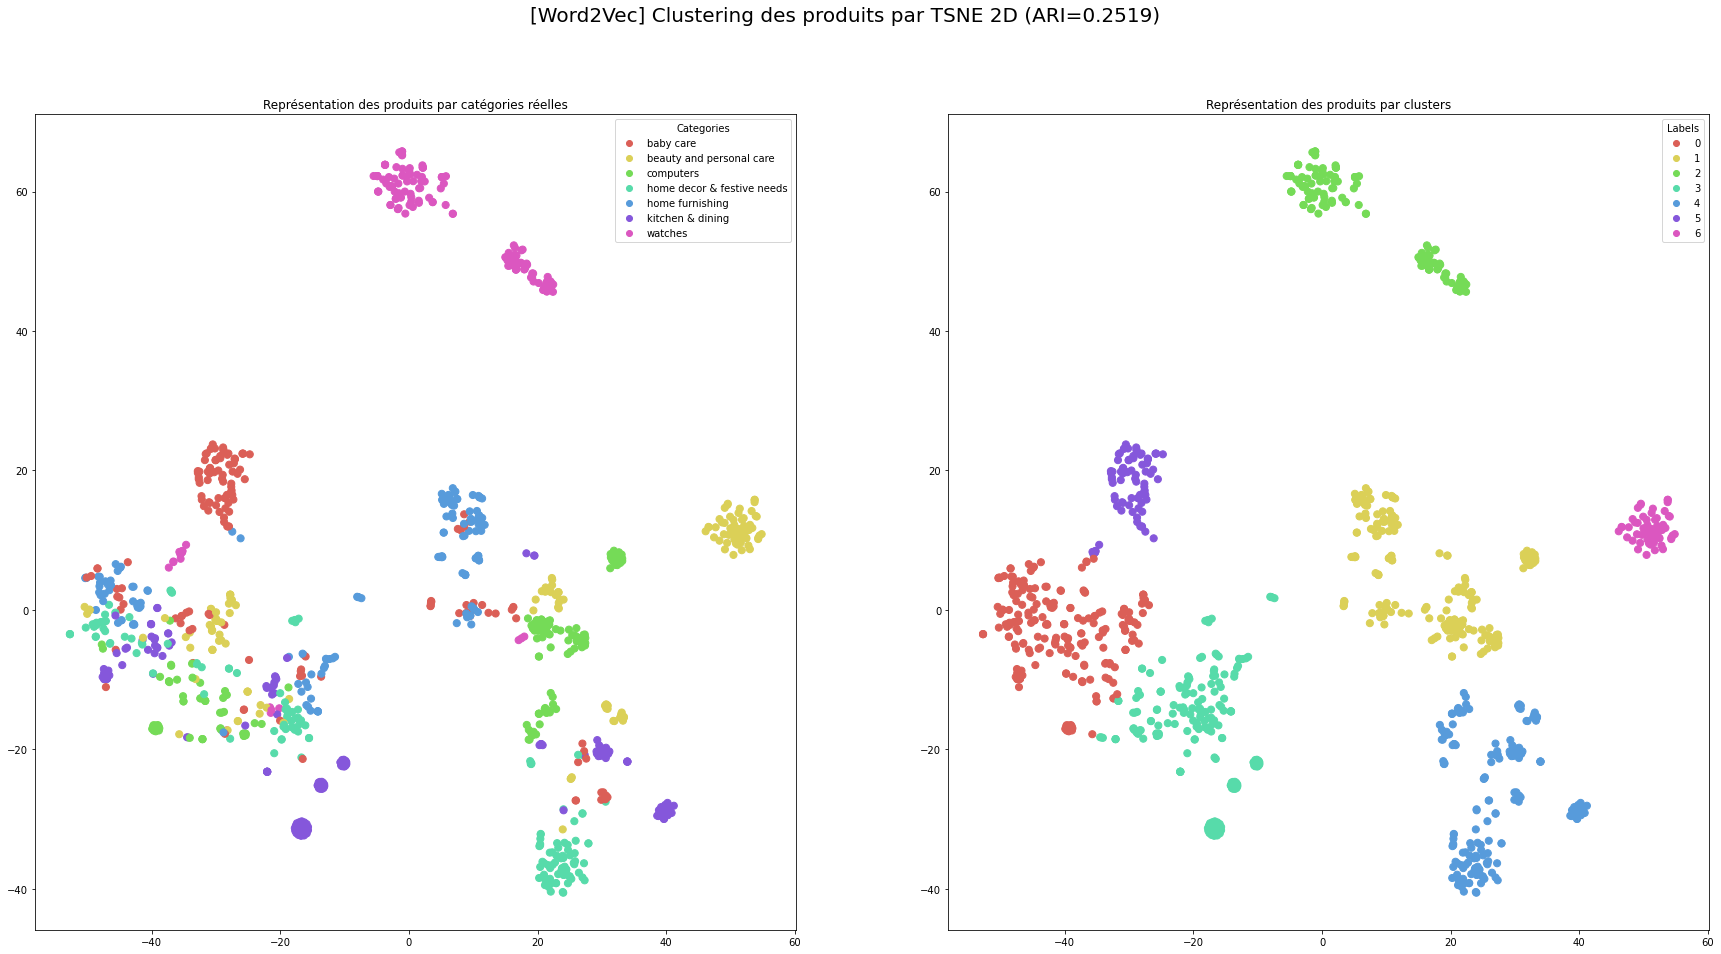

______________________________________________________________________________
Computing ARI with TSNE(3d)...
ARI with TSNE(3): 0.2204
Plot clustering...


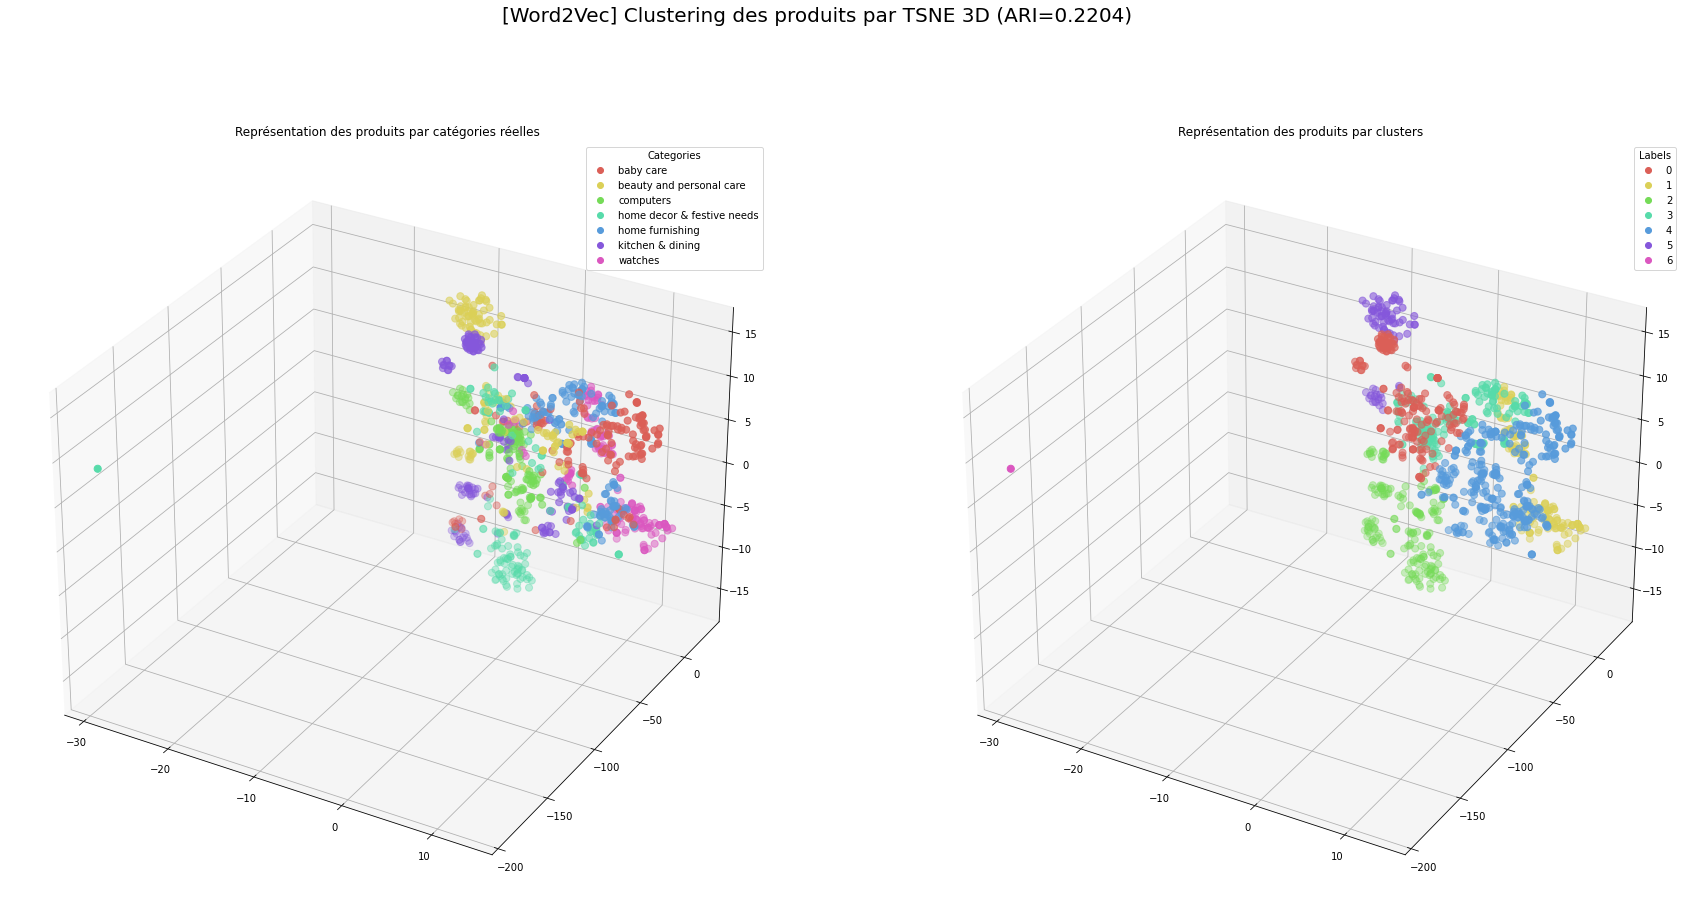

______________________________________________________________________________
Computing ARI with PCA(2d)...
ARI with PCA(2): 0.1964
Plot clustering...


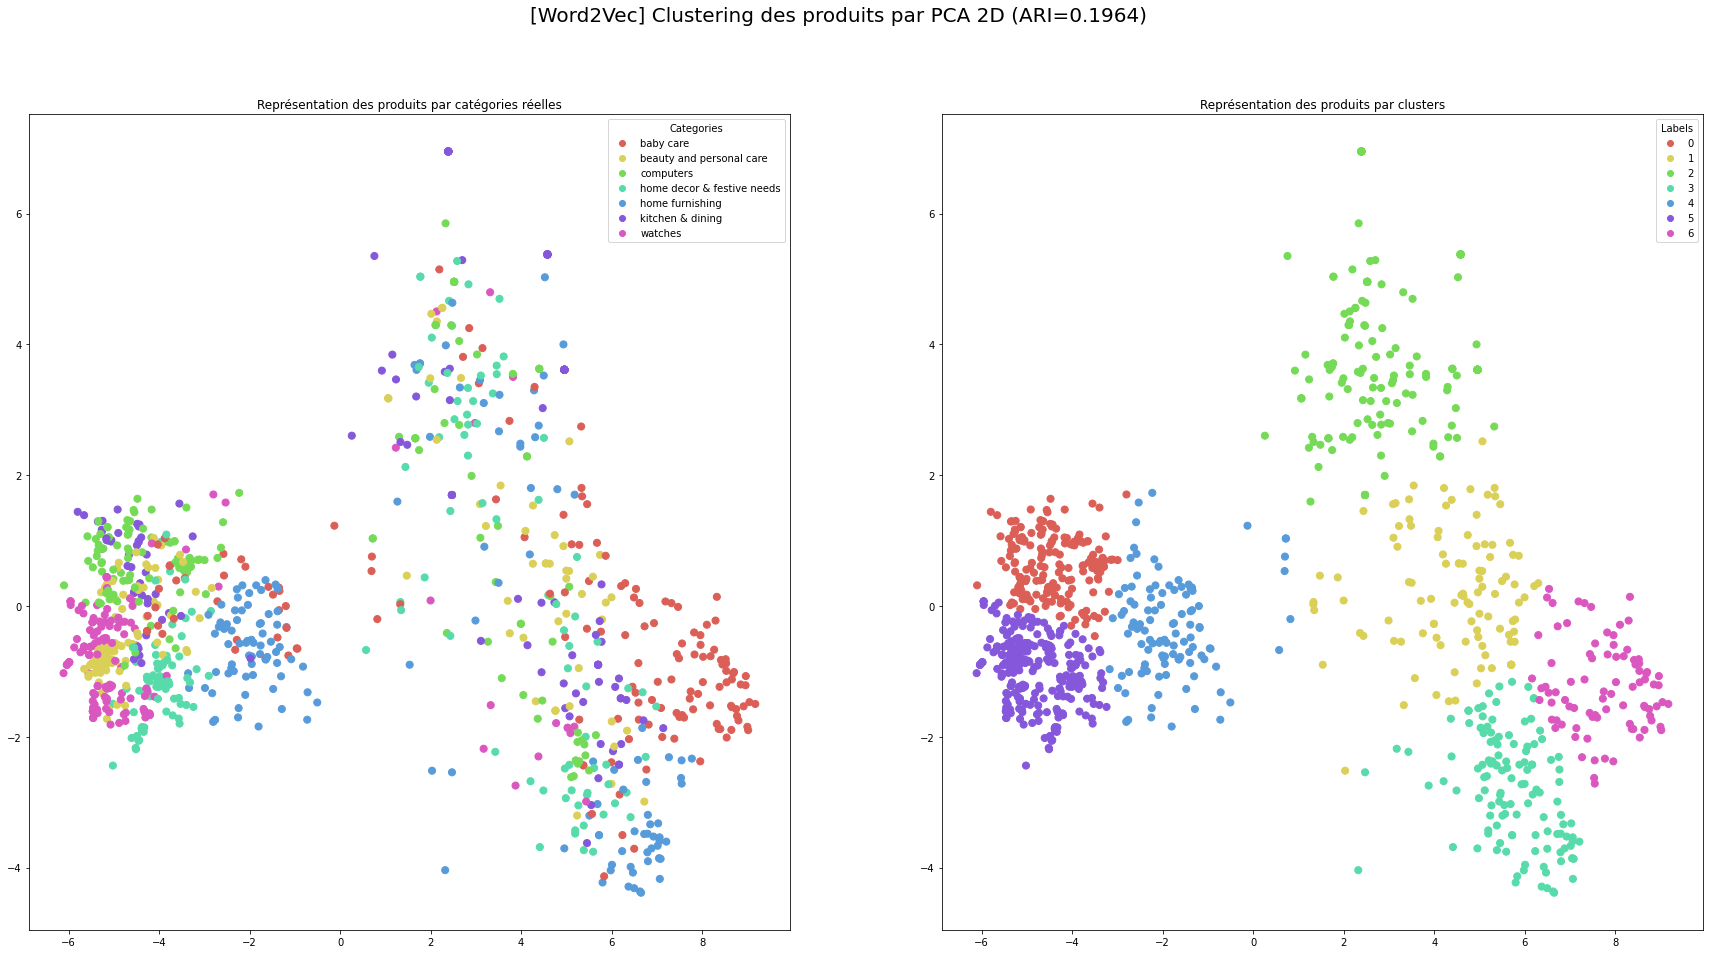

______________________________________________________________________________
Computing ARI with PCA(3d)...
ARI with PCA(3): 0.2337
Plot clustering...


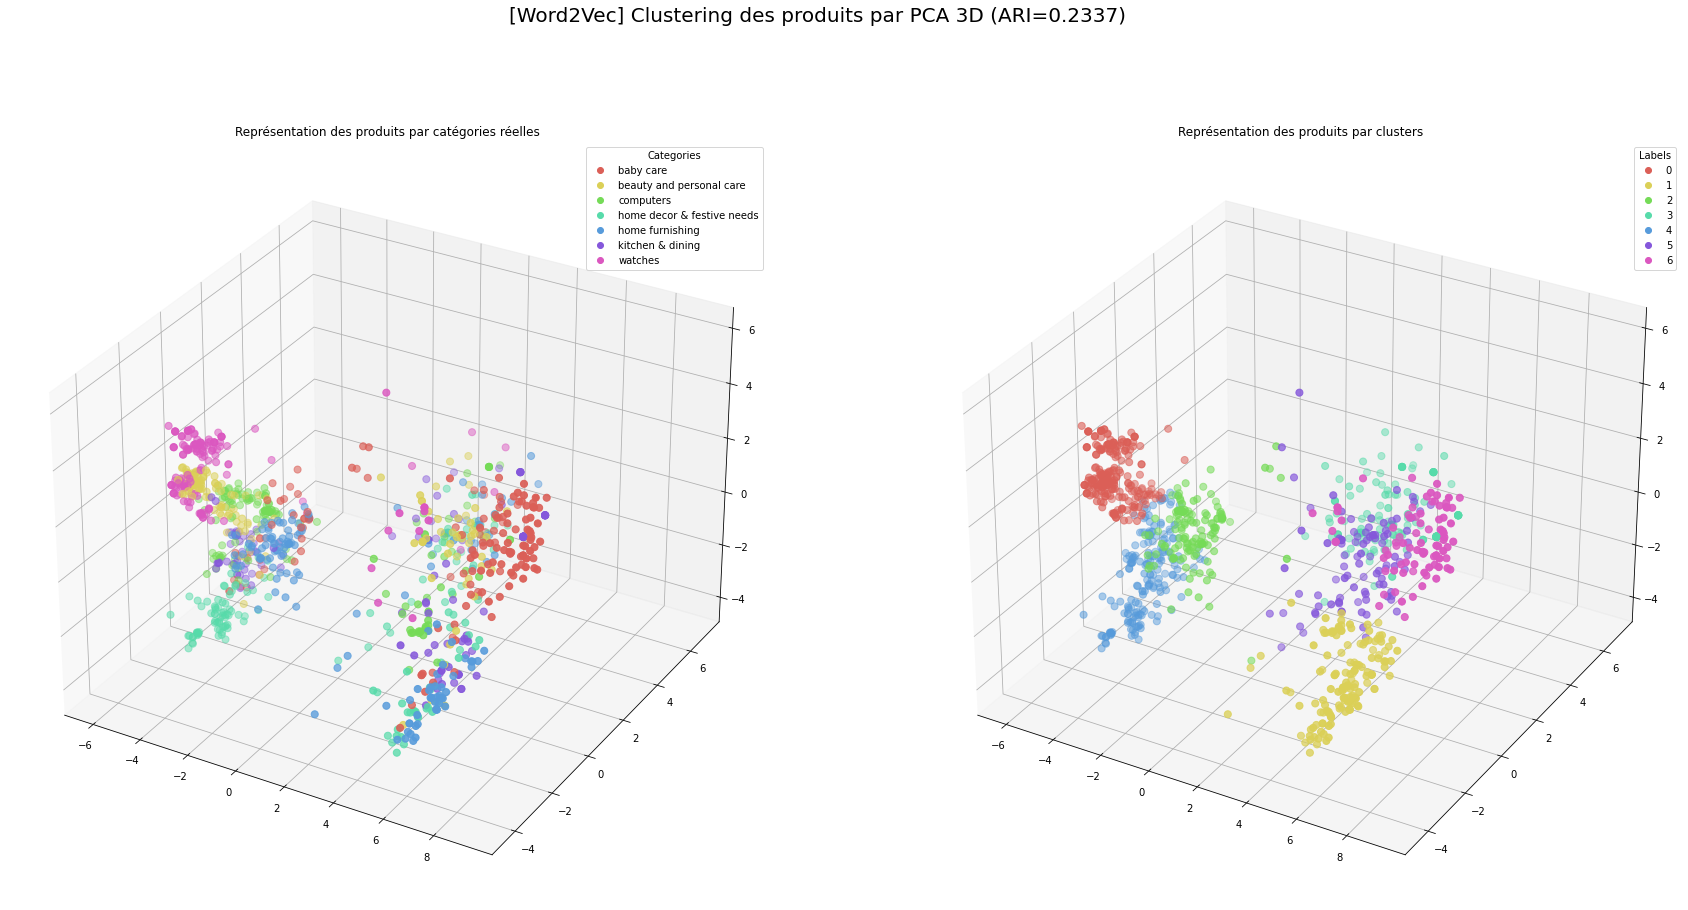

In [13]:
from sklearn.manifold import TSNE

print("_________________________________________________________________")
_df, _ari = compute_ari(embeddings, data['product_category_0'], n_components=2, model=TSNE, model_kw={'perplexity': 30, 'n_iter': 2000, 'init': 'random', 'learning_rate': 200, 'random_state': 42})
plot_clustering(_df, title=f"[Word2Vec] Clustering des produits par TSNE 2D (ARI={_ari:.4f})")

print("______________________________________________________________________________")
_df, _ari = compute_ari(embeddings, data['product_category_0'], n_components=3, model=TSNE, model_kw={'perplexity': 30, 'n_iter': 2000, 'init': 'random', 'learning_rate': 200, 'random_state': 42})
plot_clustering(_df, title=f"[Word2Vec] Clustering des produits par TSNE 3D (ARI={_ari:.4f})")

from sklearn.decomposition import PCA

print("______________________________________________________________________________")
_df, _ari = compute_ari(embeddings, data['product_category_0'], n_components=2, model=PCA)
plot_clustering(_df, title=f"[Word2Vec] Clustering des produits par PCA 2D (ARI={_ari:.4f})")

print("______________________________________________________________________________")
_df, _ari = compute_ari(embeddings, data['product_category_0'], n_components=3, model=PCA)
plot_clustering(_df, title=f"[Word2Vec] Clustering des produits par PCA 3D (ARI={_ari:.4f})")

### Word/Sentence embedding : BERT

BERT HuggingFace

'bert-base-uncased'

 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

BERT hub Tensorflow

In [14]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True,
            return_tensors="tf"
        )

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append(
            (bert_inp['input_ids'][0], bert_inp['token_type_ids'][0], bert_inp['attention_mask'][0])
        )

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], bert_tokenizer, max_length)

        if mode=='HF': # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {
                "input_word_ids": input_ids,
                "input_mask": attention_mask,
                "input_type_ids": token_type_ids
            }
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

In [15]:
# BERT 'bert-base-uncased'
from transformers import TFAutoModel, AutoTokenizer

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
data_T0 = data_T['description_tok'].apply(lambda x: ' '.join(x)).values

# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, data_T0, max_length, batch_size, mode='HF')
df_features_bert = pd.DataFrame(features_bert, index=data.index)
df_features_bert.shape

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


temps traitement :  72.0


(1050, 768)

_________________________________________________________________
Computing ARI with TSNE(2d)...
ARI with TSNE(2): 0.4118
Plot clustering...


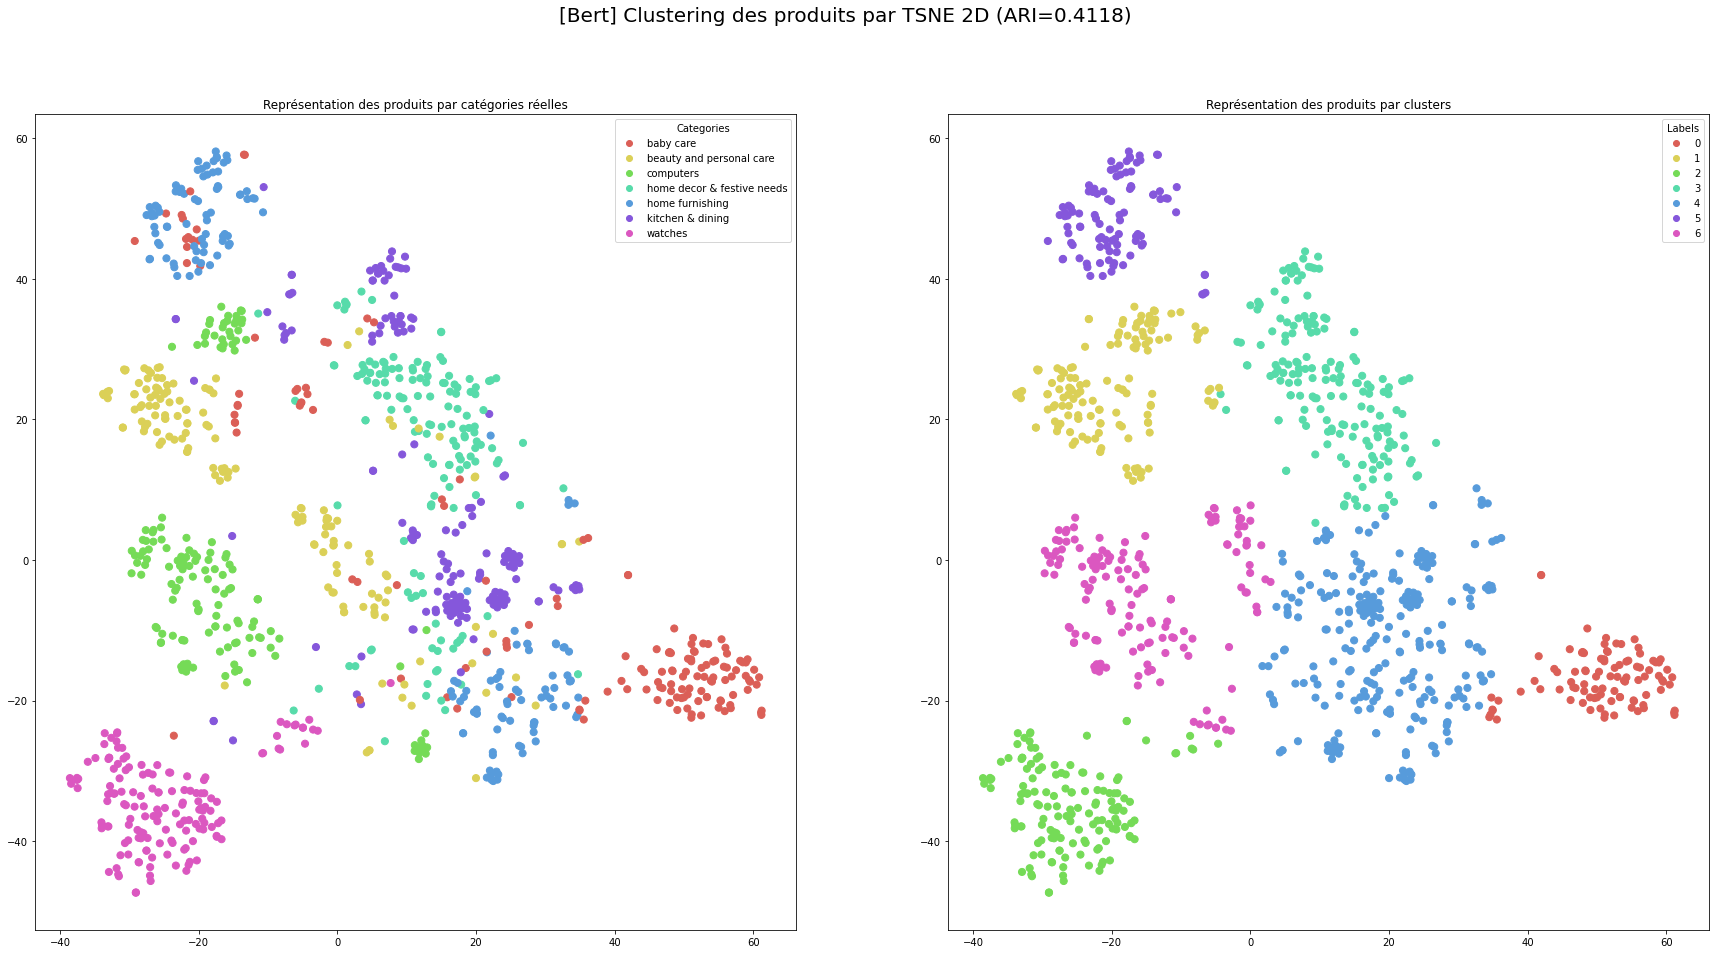

______________________________________________________________________________
Computing ARI with TSNE(3d)...
ARI with TSNE(3): 0.3548
Plot clustering...


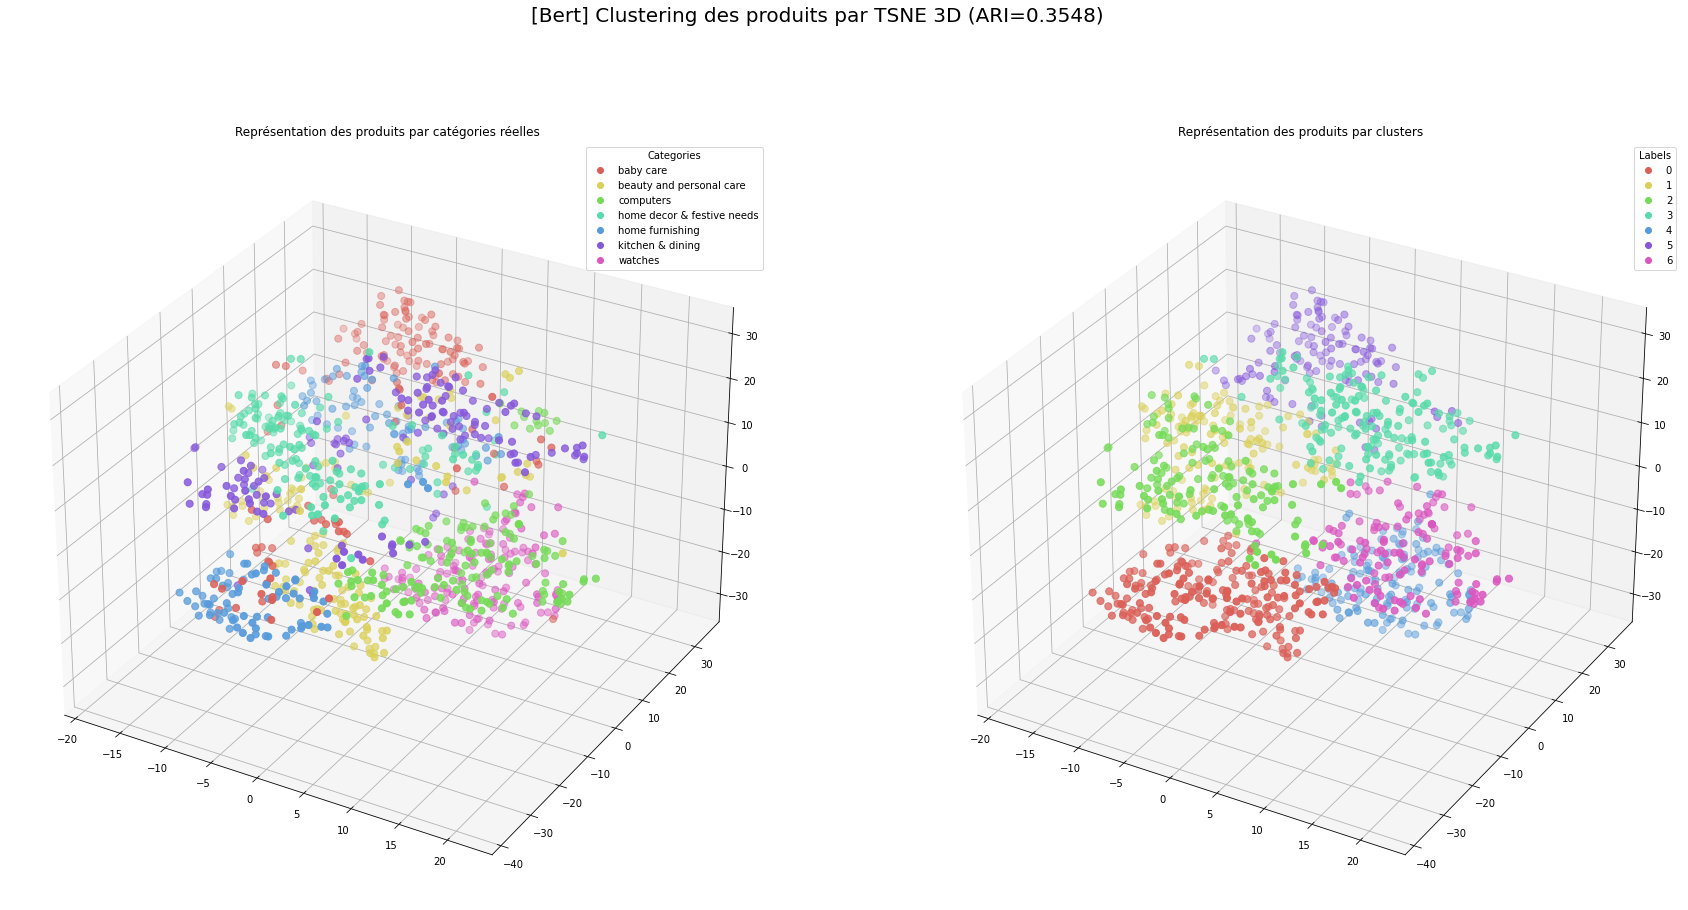

______________________________________________________________________________
Computing ARI with PCA(2d)...
ARI with PCA(2): 0.157
Plot clustering...


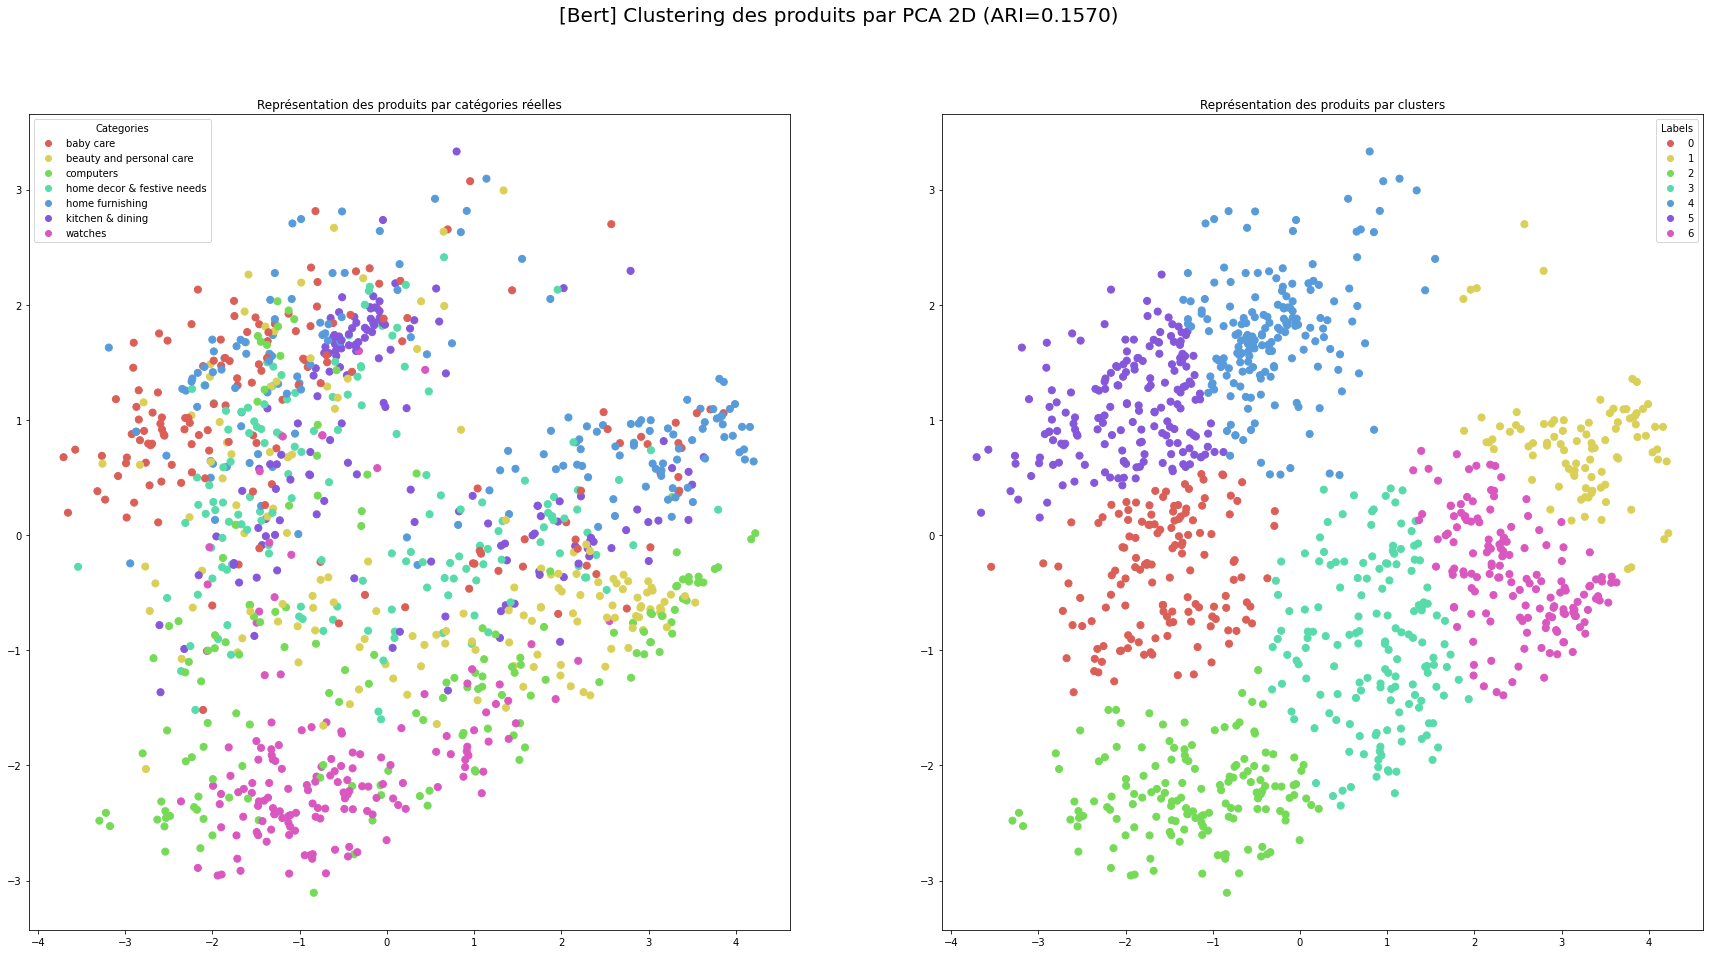

______________________________________________________________________________
Computing ARI with PCA(3d)...
ARI with PCA(3): 0.1334
Plot clustering...


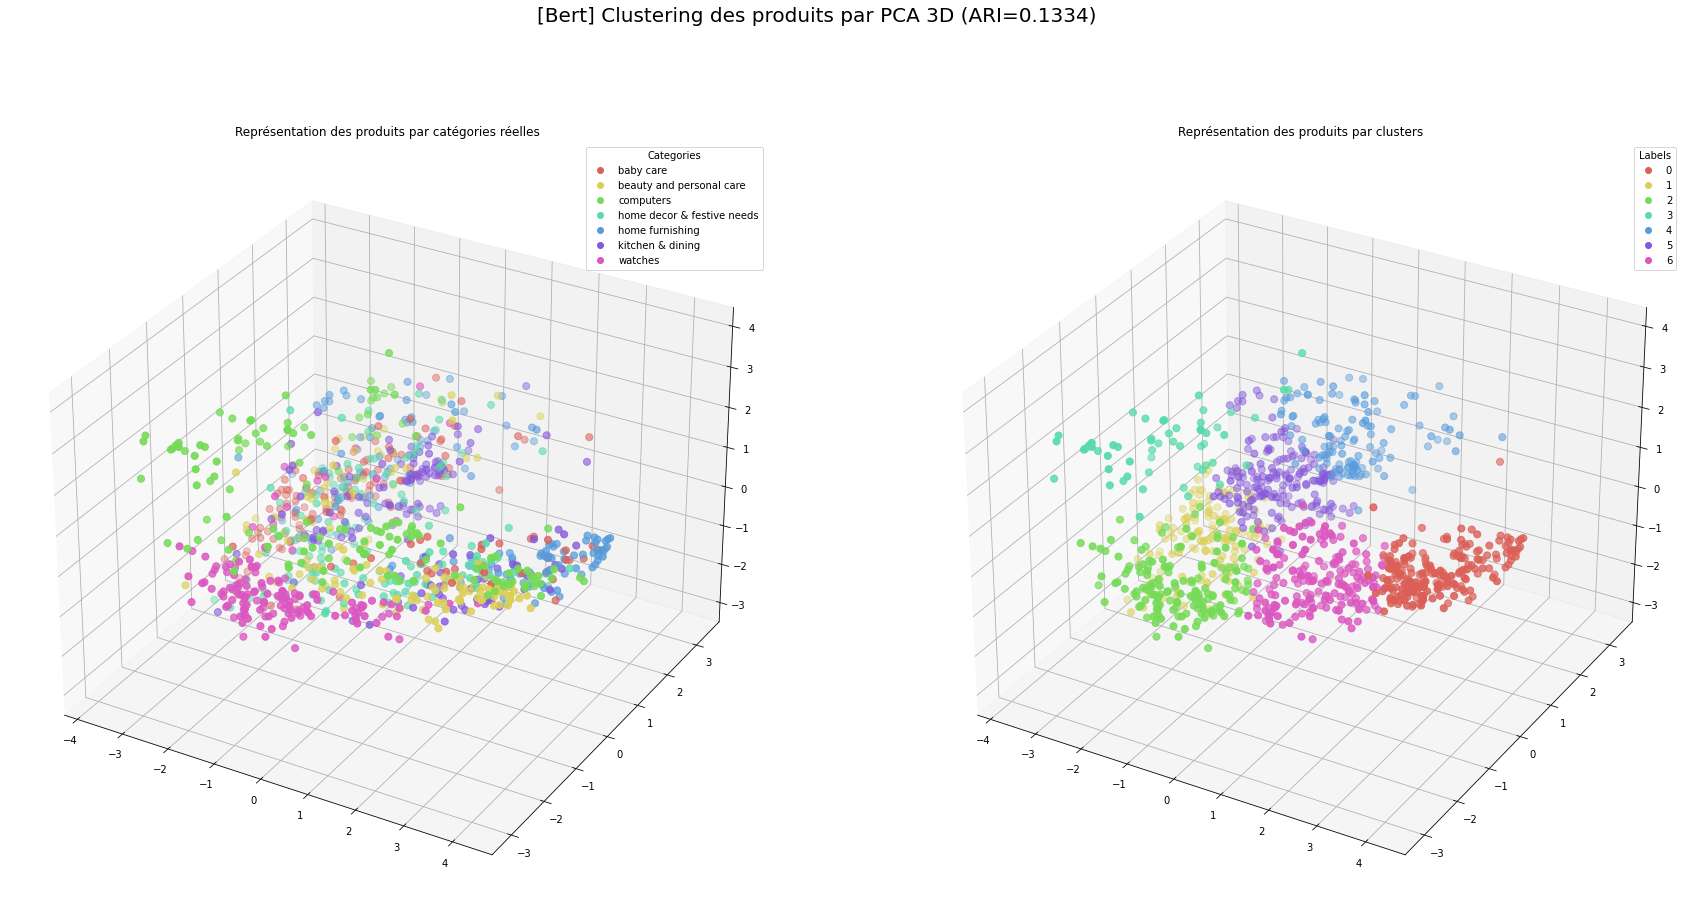

In [16]:
from sklearn.manifold import TSNE

print("_________________________________________________________________")
_df, _ari = compute_ari(df_features_bert, data['product_category_0'], n_components=2, model=TSNE, model_kw={'perplexity': 30, 'n_iter': 2000, 'init': 'random', 'learning_rate': 200, 'random_state': 42})
plot_clustering(_df, title=f"[Bert] Clustering des produits par TSNE 2D (ARI={_ari:.4f})")

print("______________________________________________________________________________")
_df, _ari = compute_ari(df_features_bert, data['product_category_0'], n_components=3, model=TSNE, model_kw={'perplexity': 30, 'n_iter': 2000, 'init': 'random', 'learning_rate': 200, 'random_state': 42})
plot_clustering(_df, title=f"[Bert] Clustering des produits par TSNE 3D (ARI={_ari:.4f})")

from sklearn.decomposition import PCA

print("______________________________________________________________________________")
_df, _ari = compute_ari(df_features_bert, data['product_category_0'], n_components=2, model=PCA)
plot_clustering(_df, title=f"[Bert] Clustering des produits par PCA 2D (ARI={_ari:.4f})")

print("______________________________________________________________________________")
_df, _ari = compute_ari(df_features_bert, data['product_category_0'], n_components=3, model=PCA)
plot_clustering(_df, title=f"[Bert] Clustering des produits par PCA 3D (ARI={_ari:.4f})")

In [17]:
# hub Tensorflow
import tensorflow_hub as hub

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
model = hub.KerasLayer(model_url, trainable=True)
data_T0 = data_T['description_tok'].apply(lambda x: ' '.join(x))

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, data_T0.to_list(), max_length, batch_size, mode='TFhub')
df_features_bert = pd.DataFrame(features_bert, index=data.index)
df_features_bert.shape

temps traitement :  68.0


(1050, 768)

_________________________________________________________________
Computing ARI with TSNE(2d)...
ARI with TSNE(2): 0.4065
Plot clustering...


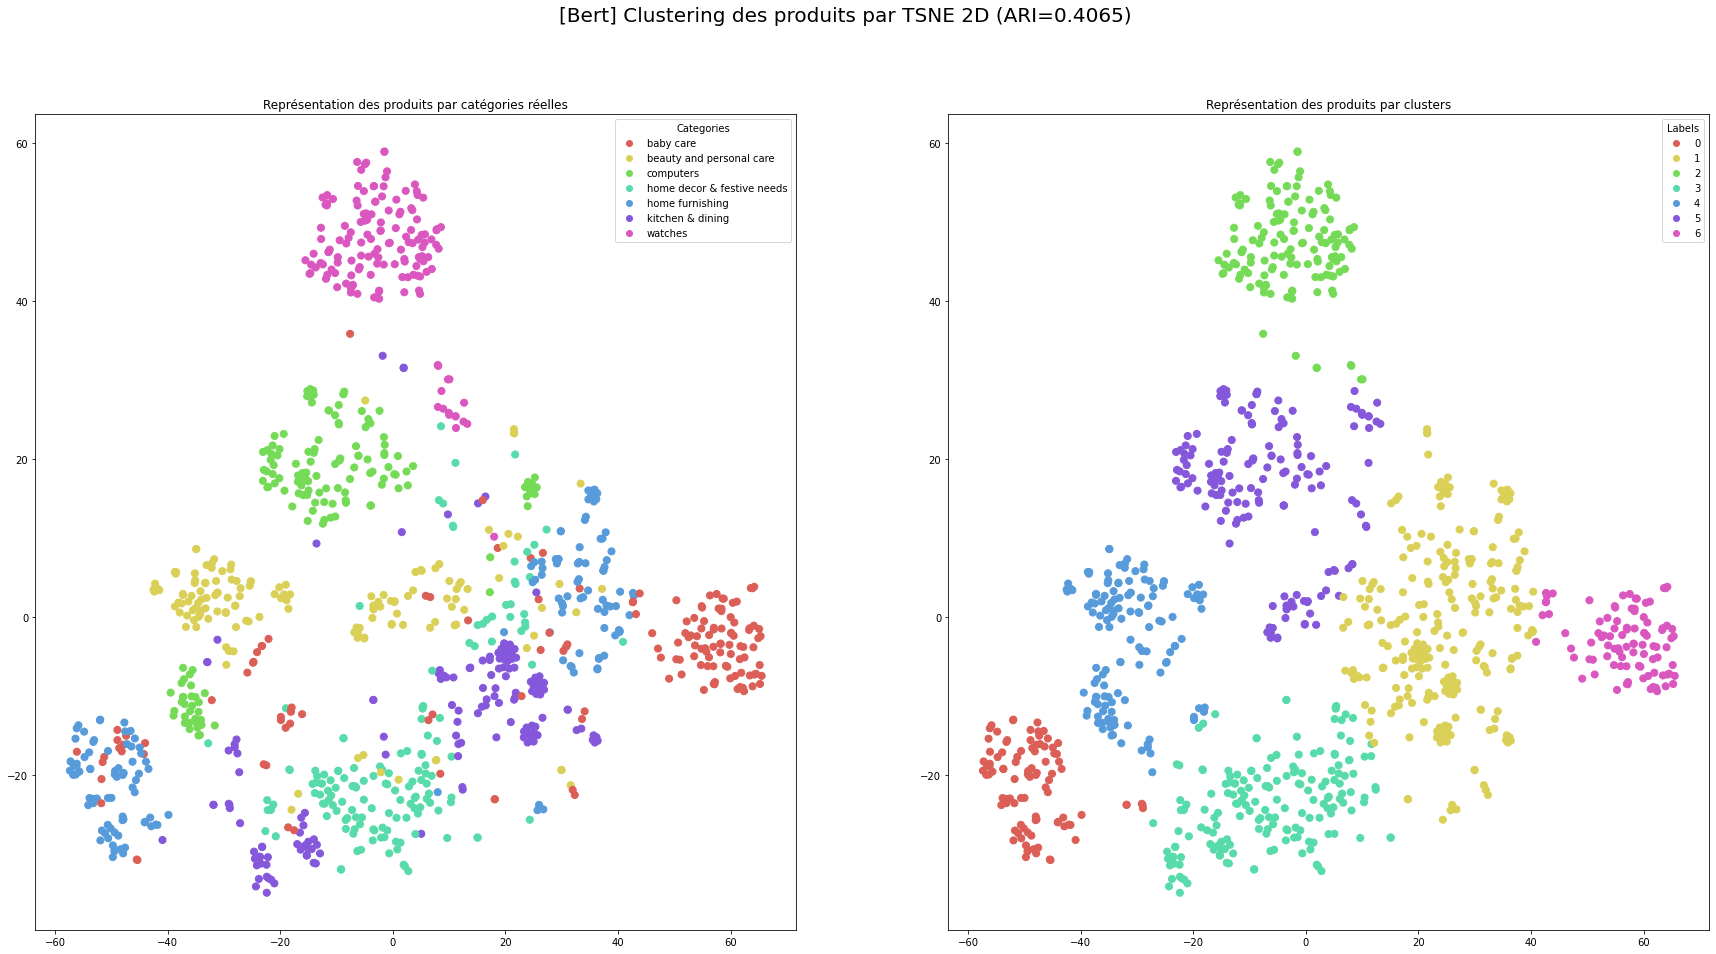

______________________________________________________________________________
Computing ARI with TSNE(3d)...
ARI with TSNE(3): 0.354
Plot clustering...


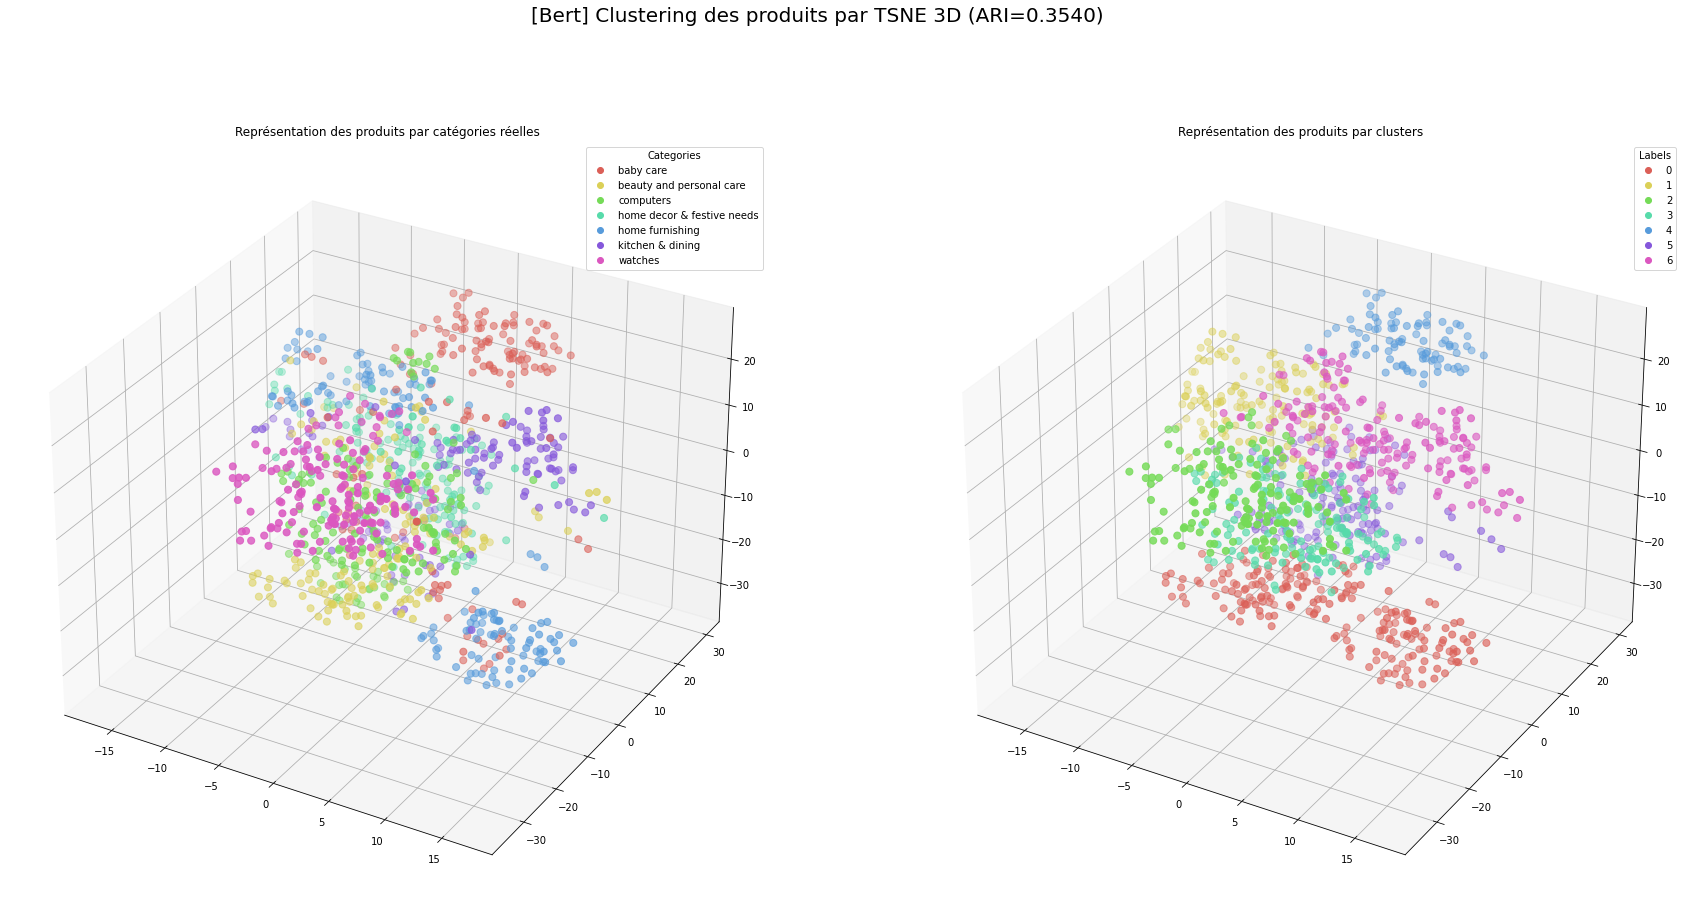

______________________________________________________________________________
Computing ARI with PCA(2d)...
ARI with PCA(2): 0.1563
Plot clustering...


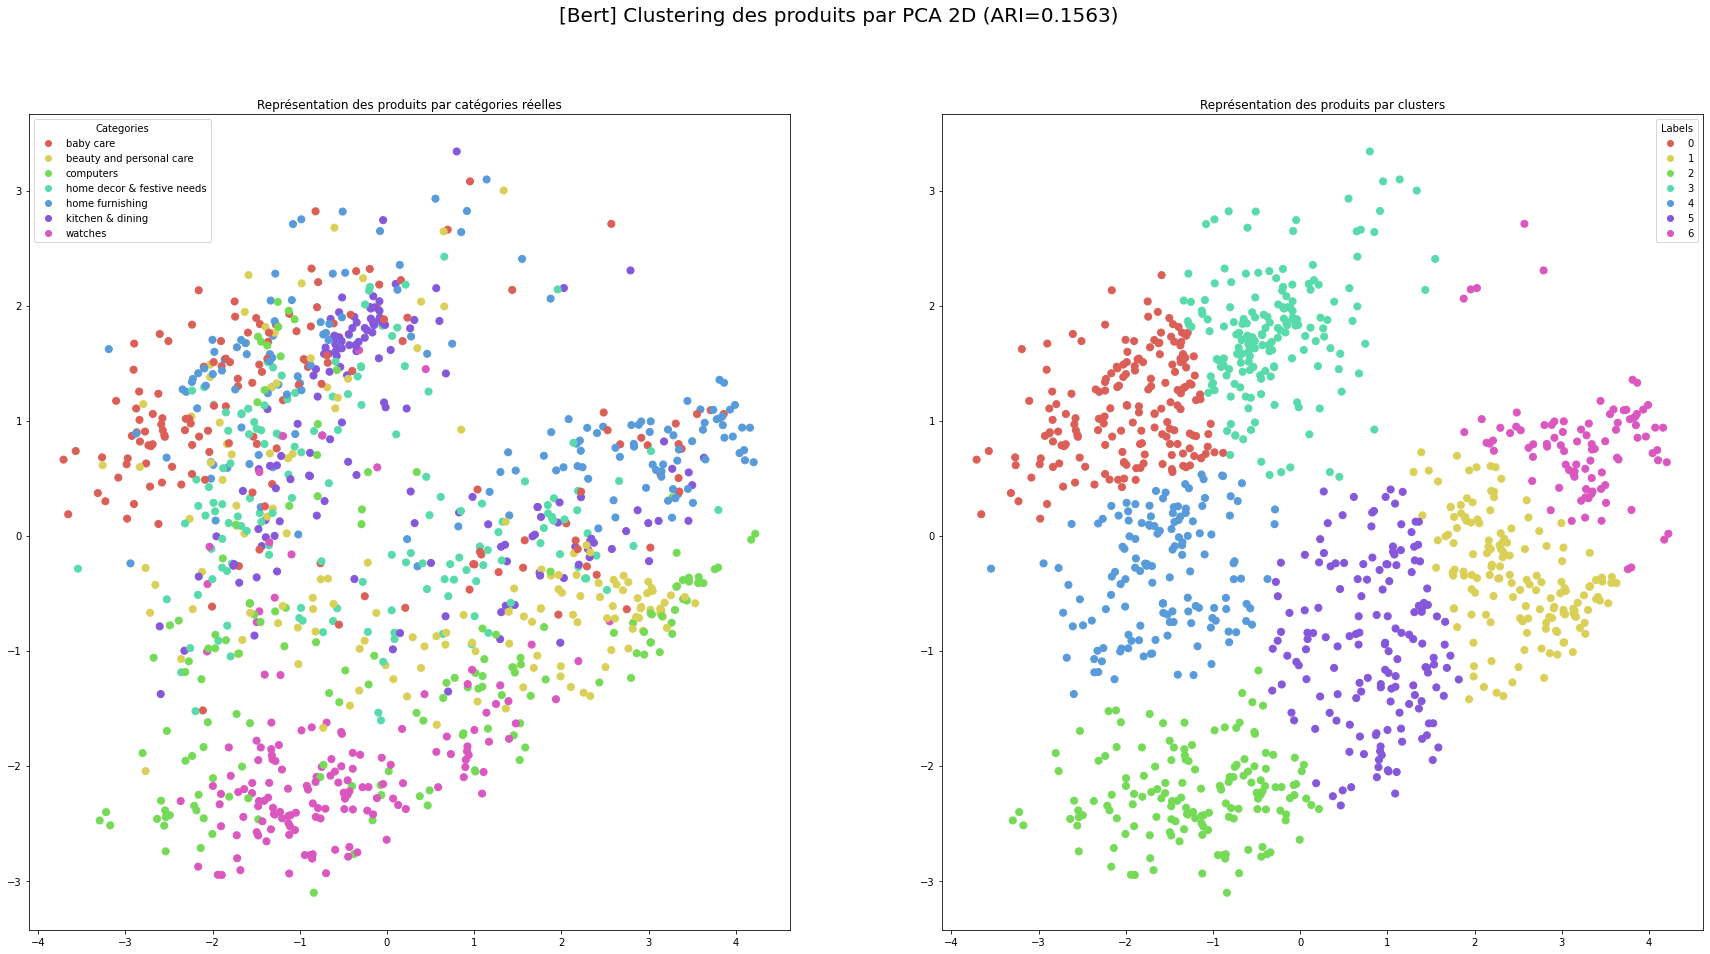

______________________________________________________________________________
Computing ARI with PCA(3d)...
ARI with PCA(3): 0.1334
Plot clustering...


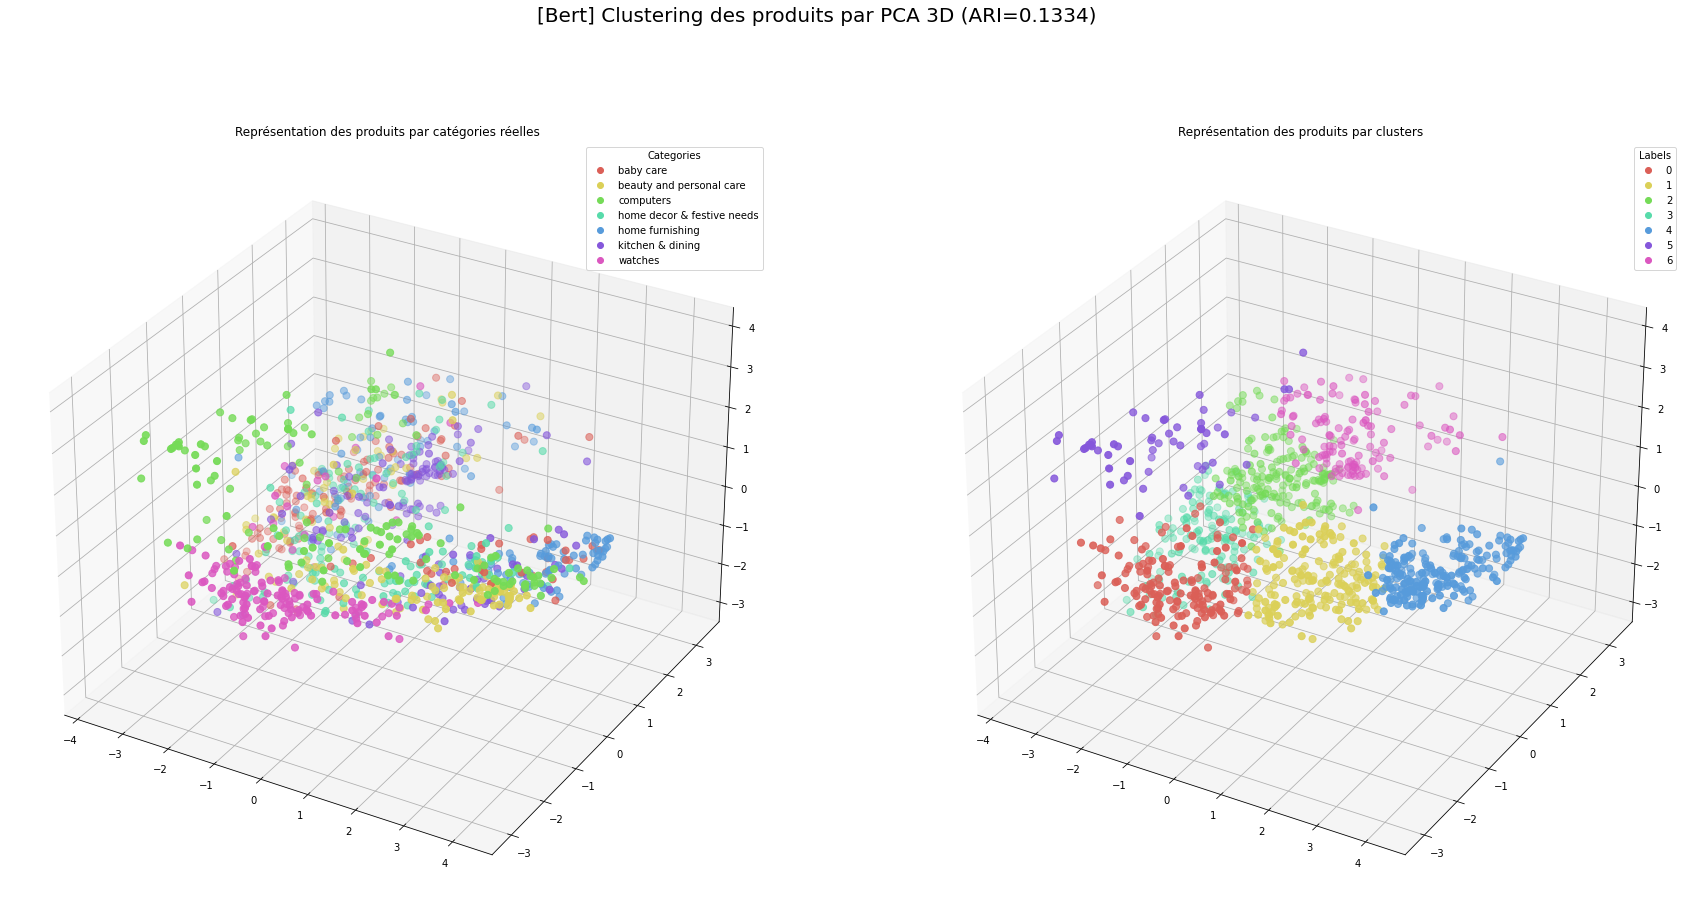

In [18]:
from sklearn.manifold import TSNE

print("_________________________________________________________________")
_df, _ari = compute_ari(df_features_bert, data['product_category_0'], n_components=2, model=TSNE, model_kw={'perplexity': 30, 'n_iter': 2000, 'init': 'random', 'learning_rate': 200, 'random_state': 42})
plot_clustering(_df, title=f"[Bert] Clustering des produits par TSNE 2D (ARI={_ari:.4f})")

print("______________________________________________________________________________")
_df, _ari = compute_ari(df_features_bert, data['product_category_0'], n_components=3, model=TSNE, model_kw={'perplexity': 30, 'n_iter': 2000, 'init': 'random', 'learning_rate': 200, 'random_state': 42})
plot_clustering(_df, title=f"[Bert] Clustering des produits par TSNE 3D (ARI={_ari:.4f})")

from sklearn.decomposition import PCA

print("______________________________________________________________________________")
_df, _ari = compute_ari(df_features_bert, data['product_category_0'], n_components=2, model=PCA)
plot_clustering(_df, title=f"[Bert] Clustering des produits par PCA 2D (ARI={_ari:.4f})")

print("______________________________________________________________________________")
_df, _ari = compute_ari(df_features_bert, data['product_category_0'], n_components=3, model=PCA)
plot_clustering(_df, title=f"[Bert] Clustering des produits par PCA 3D (ARI={_ari:.4f})")

### Word/Sentence embedding : USE

In [19]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [20]:
batch_size = 10
data_T0 = data_T['description_tok'].apply(lambda x: ' '.join(x))

features_use = feature_USE_fct(data_T0.to_list(), batch_size)
df_features_use = pd.DataFrame(features_use, index=data.index)
df_features_use.shape

(1050, 512)

_________________________________________________________________
Computing ARI with TSNE(2d)...
ARI with TSNE(2): 0.5047
Plot clustering...


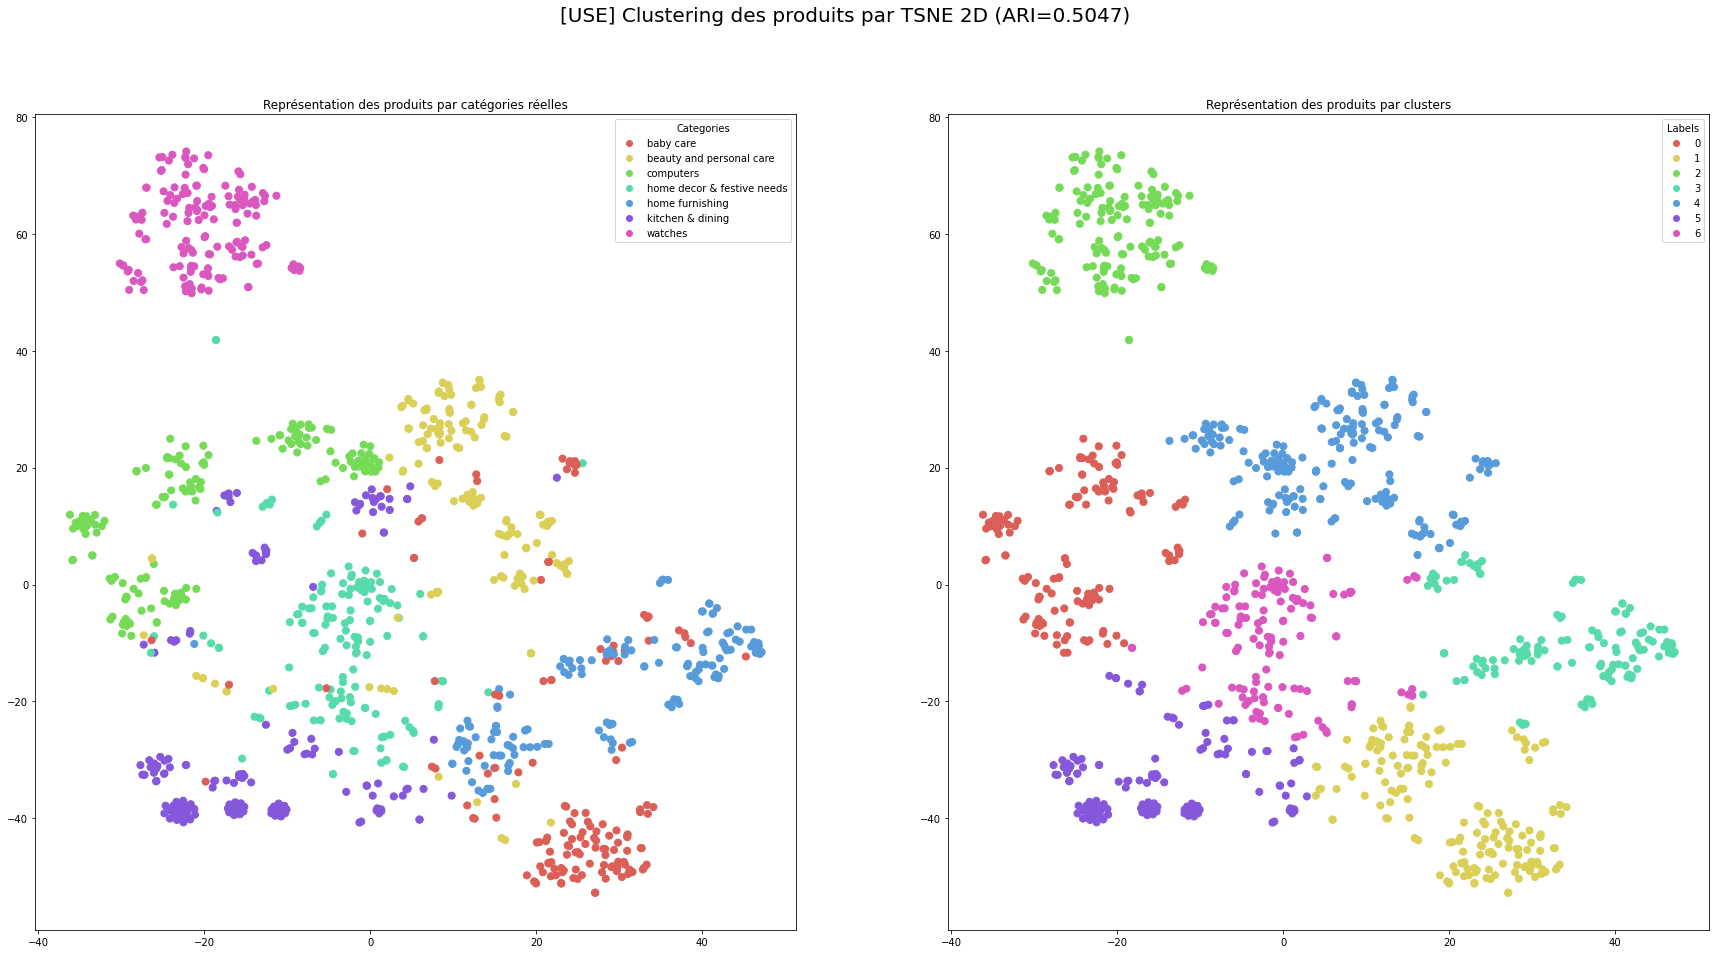

______________________________________________________________________________
Computing ARI with TSNE(3d)...
ARI with TSNE(3): 0.4499
Plot clustering...


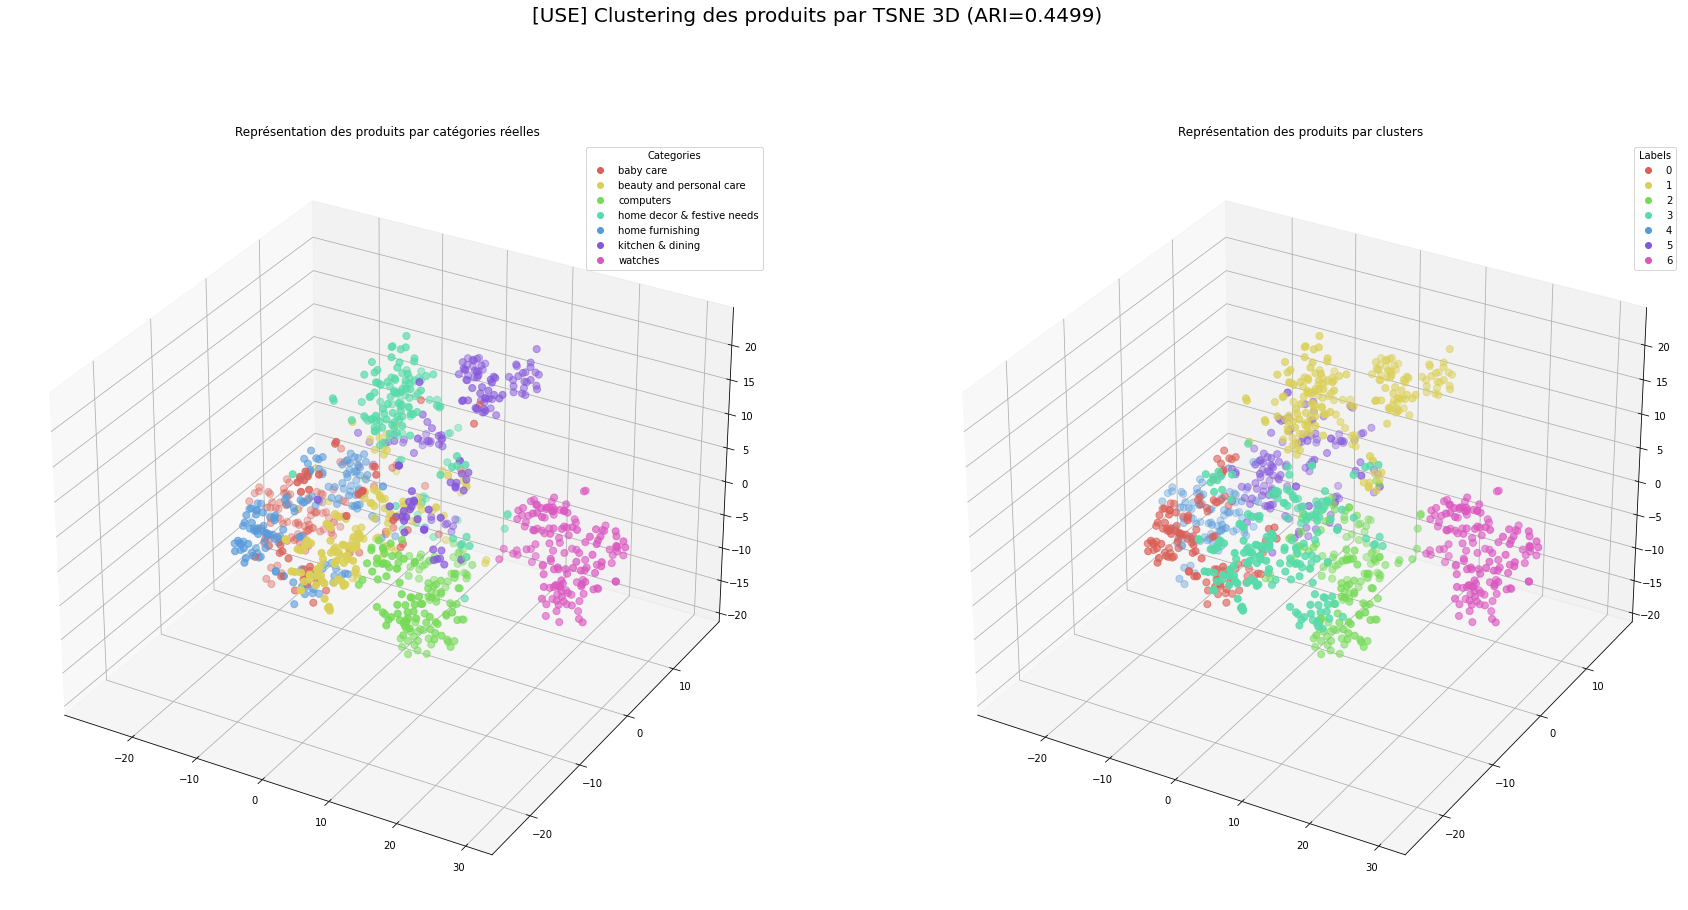

______________________________________________________________________________
Computing ARI with PCA(2d)...
ARI with PCA(2): 0.279
Plot clustering...


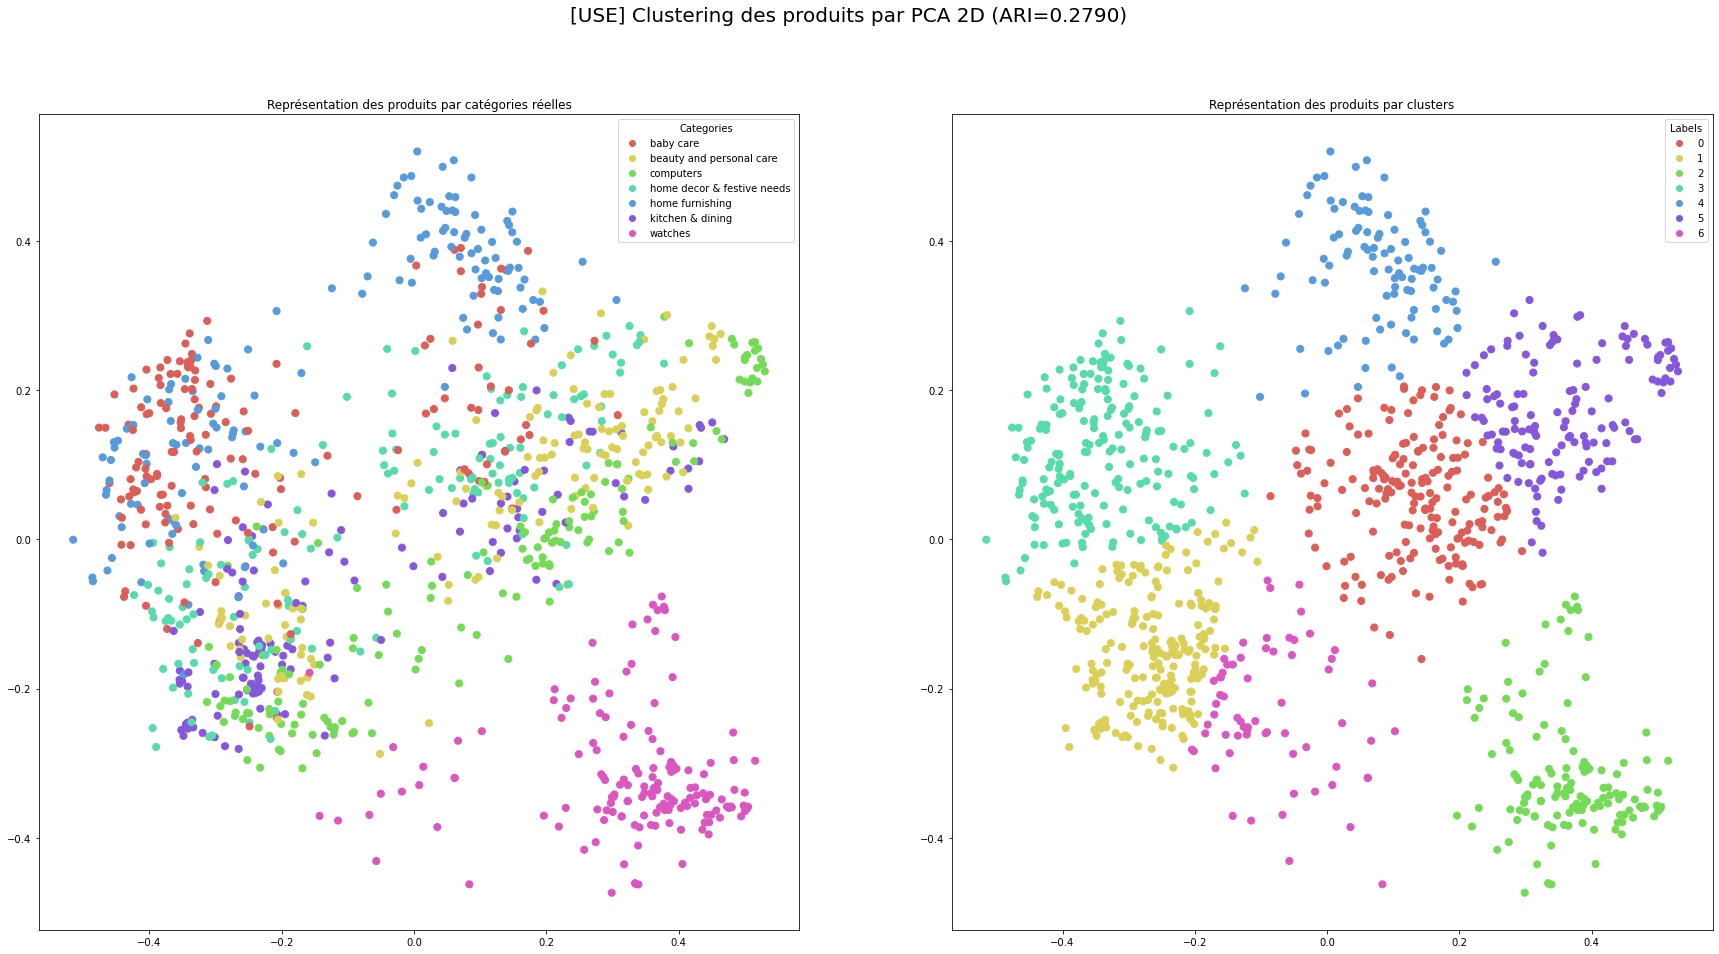

______________________________________________________________________________
Computing ARI with PCA(3d)...
ARI with PCA(3): 0.2903
Plot clustering...


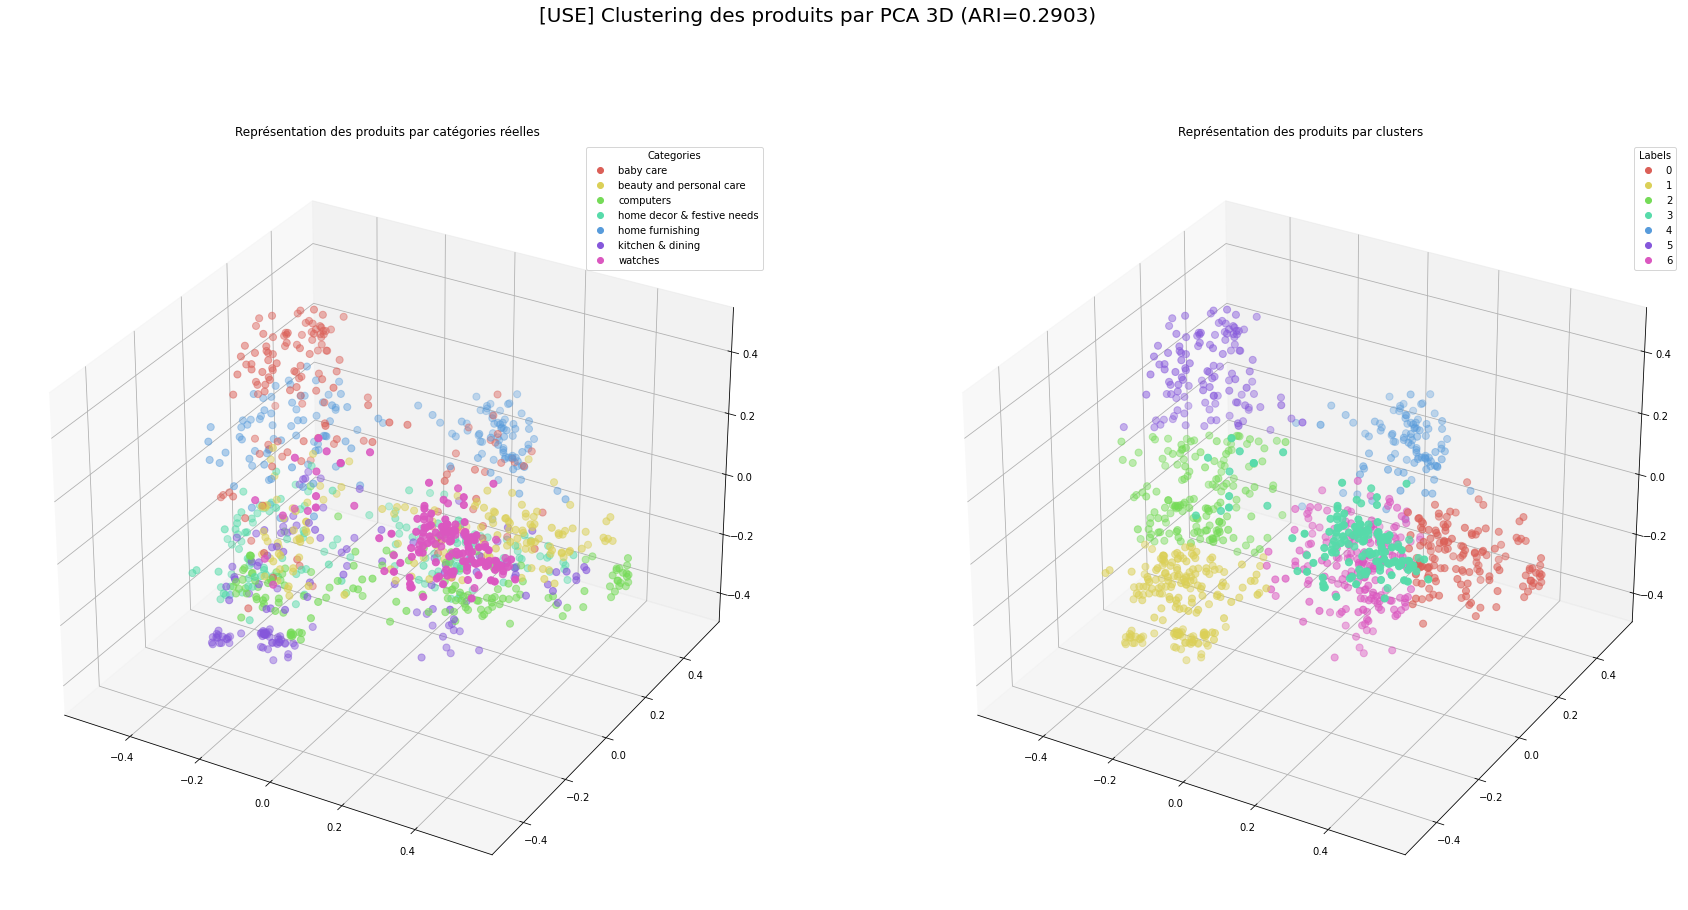

In [21]:
from sklearn.manifold import TSNE

print("_________________________________________________________________")
_df, _ari = compute_ari(df_features_use, data['product_category_0'], n_components=2, model=TSNE, model_kw={'perplexity': 30, 'n_iter': 2000, 'init': 'random', 'learning_rate': 200, 'random_state': 42})
plot_clustering(_df, title=f"[USE] Clustering des produits par TSNE 2D (ARI={_ari:.4f})")

print("______________________________________________________________________________")
_df, _ari = compute_ari(df_features_use, data['product_category_0'], n_components=3, model=TSNE, model_kw={'perplexity': 30, 'n_iter': 2000, 'init': 'random', 'learning_rate': 200, 'random_state': 42})
plot_clustering(_df, title=f"[USE] Clustering des produits par TSNE 3D (ARI={_ari:.4f})")

from sklearn.decomposition import PCA

print("______________________________________________________________________________")
_df, _ari = compute_ari(df_features_use, data['product_category_0'], n_components=2, model=PCA)
plot_clustering(_df, title=f"[USE] Clustering des produits par PCA 2D (ARI={_ari:.4f})")

print("______________________________________________________________________________")
_df, _ari = compute_ari(df_features_use, data['product_category_0'], n_components=3, model=PCA)
plot_clustering(_df, title=f"[USE] Clustering des produits par PCA 3D (ARI={_ari:.4f})")

### Export du notebook en HTML

In [23]:
!jupyter nbconvert --config nbconvert/config_html.py

[NbConvertApp] Converting notebook P6_01_notebookexploration.ipynb to html
[NbConvertApp] Writing 787215 bytes to P6_01_notebookexploration.html
[NbConvertApp] Converting notebook P6_02_notebookbagofword.ipynb to html
[NbConvertApp] Writing 3641906 bytes to P6_02_notebookbagofword.html
[NbConvertApp] Converting notebook P6_03_notebookembedding.ipynb to html
[NbConvertApp] Writing 8347677 bytes to P6_03_notebookembedding.html
[NbConvertApp] Converting notebook P6_04_notebookimages.ipynb to html
[NbConvertApp] Writing 47617971 bytes to P6_04_notebookimages.html
